An implementation of Fully-Connected Autoencoder
aiming for dimensionality reduction
provided for Machine earning Course, KNTU, Spring 2024.

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2024-04-20: Initial coding

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
lr = 3e-4
batch_size = 64
num_epochs = 50

In [ ]:
transform = transforms.ToTensor()

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [ ]:
x = torch.rand(64, 784)
linear1 = nn.Linear(28 * 28, 128)
x1 = linear1(x)
print(x1.shape)
linear2 = nn.Linear(128, 16)
x2 = linear2(x1)
print(x2.shape)

torch.Size([64, 128])
torch.Size([64, 16])


In [ ]:
# Dense Autoencoder model
class Dense_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
model = Dense_Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

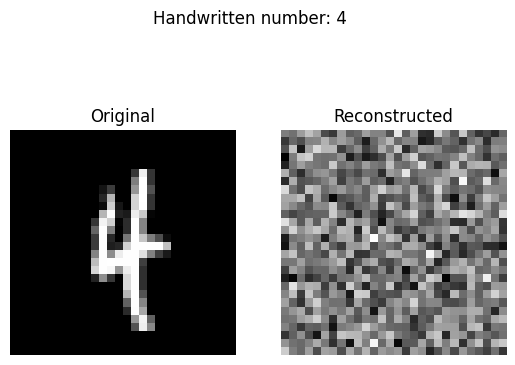

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
plt.subplot(1, 2, 1)
plt.imshow(images[0][0], cmap='gray')
plt.title("Original")
plt.axis("off")
plt.subplot(1, 2, 2)
model.eval()
with torch.no_grad():
  z, xh = model(images[0][0].reshape(-1, 28*28).to(device))
  xh = xh.reshape(-1, 28,28).detach().cpu().numpy()
model.train()
plt.imshow(xh[0], cmap='gray')
plt.title("Reconstructed")
plt.axis("off")
plt.suptitle("Handwritten number: " + str(labels[0].item()))
plt.show()

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (img, _) in enumerate(tqdm(train_loader)):
        img = img.reshape(-1, 28*28).to(device)
        _, recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 938/938 [00:09<00:00, 103.60it/s]


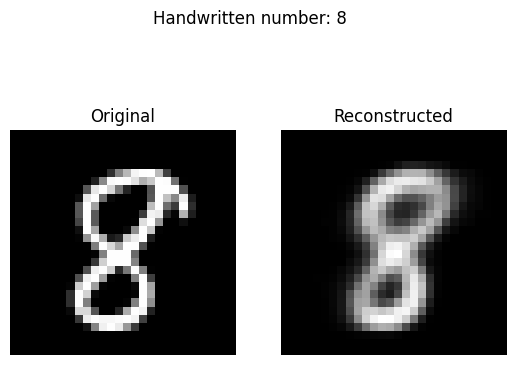

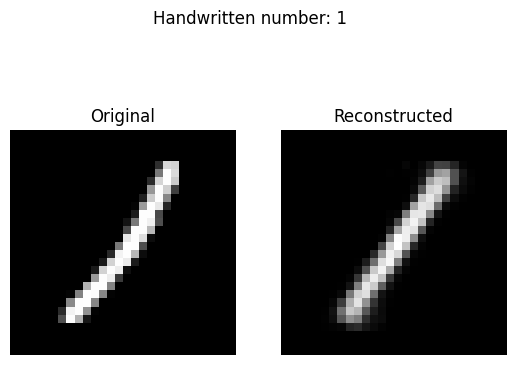

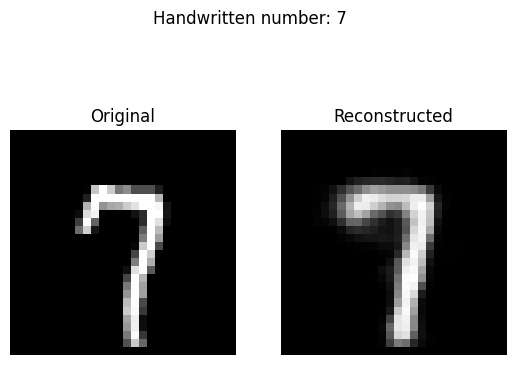

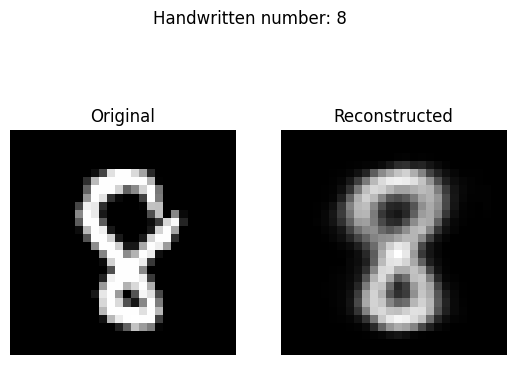

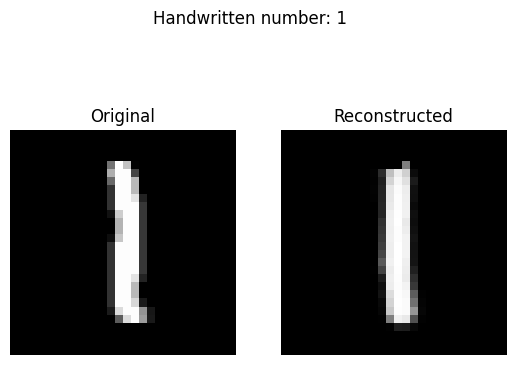

In [ ]:
model.eval()
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
      if batch_idx <5:
        x = x.to(device=device)
        z, xh = model(x.reshape(-1, 28*28))
        xh = xh.reshape(-1, 28,28).detach().cpu().numpy()
        plt.subplot(1, 2, 1)
        plt.imshow(x[0][0].cpu().numpy(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(xh[0], cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
        plt.suptitle("Handwritten number: " + str(y[0].item()))
        plt.show()
      else:
        break

In [ ]:
print(model)

Dense_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
print(model.encoder(torch.rand(64, 28*28).to(device)).shape)
print(model.decoder(torch.rand(64, 3).to(device)).shape)

torch.Size([64, 3])
torch.Size([64, 784])


# Custom Dataset

In [ ]:
x = np.random.rand(1000, 784)
y = np.random.rand(1000)

# transform = transforms.ToTensor()

class CustomDataSet(Dataset):
    def __init__(self, features, targets, transform=None):
      self.features = features
      self.targets = targets
      self.transform = transform
      self.num_samples = features.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        x = torch.tensor(self.features[index]).to(torch.float32)
        y = torch.tensor(int(self.targets[index]))

        # if self.transform:
        #     x = self.transform(x)

        return x, y

dset = CustomDataSet(x, y)
loader = DataLoader(dataset=dset, batch_size=batch_size, shuffle=True)
print("*************************** Information of a single sample ***************************")
data, target = dset[10]
print(data.shape, target.shape)
print(data.dtype, target.dtype)
print("*************************** Information of a batch of samples ***************************")
dataiter = iter(loader)
data, target = next(dataiter)
print(data.shape, target.shape)
print(data.dtype, target.dtype)
print("*************************** Information of a batch of samples before/after being passed to model ***************************")
for batch_idx, (x, y) in enumerate(loader):
  if batch_idx == 0:
    print(x.shape, y.shape)
    print(x.dtype, y.dtype)
    with torch.no_grad():
      z, xh = model(x.to(device))
      print(z.shape, xh.shape)
  else:
    break

*************************** Information of a single sample ***************************
torch.Size([784]) torch.Size([])
torch.float32 torch.int64
*************************** Information of a batch of samples ***************************
torch.Size([64, 784]) torch.Size([64])
torch.float32 torch.int64
*************************** Information of a batch of samples before/after being passed to model ***************************
torch.Size([64, 784]) torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 3]) torch.Size([64, 784])
